# Titanic Survival prediction
    A notebook to give me a kickstart working with pytorch, numpy, pandas and pyplot

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch # out tool for applied machine learning
import torch.nn as nn
import torch.nn.functional as F
# remember, we are using data variable for torch.utils.data and not for our actual dataset
import torch.utils.data as data
import torch.optim as optim

import matplotlib.pyplot as plt # to plot graphs 

In [2]:
data_path = '.\\'

In [3]:
training_data = pd.read_csv(data_path+'train.csv')
testing_data = pd.read_csv(data_path+'test.csv')

In [4]:
# code to see if there are NaN values in the dataset
print('{} values with Age null in training set'.format(pd.isnull(training_data.Age).sum()))
print('{} values with Age null in testing set'.format(pd.isnull(testing_data.Age).sum()))

177 values with Age null in training set
86 values with Age null in testing set


In [5]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
testing_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
class TitanicDataset (data.Dataset):
    
    def __init__(self, file_name, Train=True):
        self.dataframe = pd.read_csv(file_name)
        """ drop all the rows which has null age, currently we are only concerned with age
        however, other column values may also be null but we are only using Age, Passenger class
        and gender to train our model
        """
        self.dataframe = self.dataframe[~self.dataframe['Age'].isnull()]
        self.dataframe = self.dataframe.reset_index()
        self.Train = Train
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        if(torch.is_tensor(idx)):
            idx = idx.tolist();
        if(self.Train):
            survived = self.dataframe['Survived']
            survived = np.array(survived)[idx]
        features = pd.DataFrame(columns=('Sex', 'Pclass', 'Age'))
        features.loc[idx] = [ 1 if self.dataframe.loc[idx]['Sex']=='male' else 0, \
                              self.dataframe.loc[idx,'Pclass'],\
                              self.dataframe.loc[idx,'Age']]
        features = np.array(features)
        if(self.Train):
            sample = ( features, survived )
        else:
            sample = features
        return sample
    
    def __info__(self):
        return self.dataframe.info()

In [8]:
training_data = TitanicDataset(data_path+'train.csv')
testing_data = TitanicDataset(data_path+'test.csv', Train=False)

In [9]:
training_data.__getitem__(4)

(array([[ 1.,  3., 35.]]), 0)

In [10]:
testing_data.__getitem__(2)

# print the resulting dataset length after filtering out the null values
print('training dataset length: {}'.format(training_data.__len__()))
print('testing dataset length: {}'.format(testing_data.__len__()))

training dataset length: 714
testing dataset length: 332


In [11]:
testing_data.__len__()

332

In [12]:
testing_data.__info__()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        332 non-null    int64  
 1   PassengerId  332 non-null    int64  
 2   Pclass       332 non-null    int64  
 3   Name         332 non-null    object 
 4   Sex          332 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        332 non-null    int64  
 7   Parch        332 non-null    int64  
 8   Ticket       332 non-null    object 
 9   Fare         331 non-null    float64
 10  Cabin        87 non-null     object 
 11  Embarked     332 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 31.3+ KB


In [13]:
training_dataloader = data.DataLoader(training_data, shuffle=True, batch_size=100)

In [14]:
# print sample training batch examples from our dataset
train_example_iterator = iter(training_dataloader)
print(next(train_example_iterator))

[tensor([[[ 1.0000,  3.0000, 24.0000]],

        [[ 1.0000,  3.0000, 22.0000]],

        [[ 1.0000,  2.0000, 23.0000]],

        [[ 0.0000,  1.0000, 25.0000]],

        [[ 1.0000,  3.0000, 24.0000]],

        [[ 1.0000,  2.0000, 25.0000]],

        [[ 1.0000,  2.0000, 52.0000]],

        [[ 1.0000,  3.0000, 34.0000]],

        [[ 0.0000,  1.0000, 21.0000]],

        [[ 1.0000,  3.0000, 25.0000]],

        [[ 1.0000,  1.0000,  4.0000]],

        [[ 1.0000,  3.0000, 16.0000]],

        [[ 1.0000,  3.0000, 31.0000]],

        [[ 1.0000,  1.0000, 70.0000]],

        [[ 0.0000,  3.0000, 24.0000]],

        [[ 0.0000,  1.0000, 47.0000]],

        [[ 1.0000,  3.0000, 28.5000]],

        [[ 1.0000,  2.0000, 34.0000]],

        [[ 1.0000,  1.0000, 45.0000]],

        [[ 1.0000,  2.0000, 21.0000]],

        [[ 1.0000,  2.0000, 70.0000]],

        [[ 0.0000,  3.0000, 36.0000]],

        [[ 1.0000,  1.0000,  0.9200]],

        [[ 1.0000,  1.0000, 40.0000]],

        [[ 0.0000,  2.0000, 57.0000]],


### Death distribution by gender

Not going to run this code, this is just for reference for making a bar chart
```python
fig = plt.figure(figsize=(8,6))
bar_width=0.4
for i in np.arange(len(gender)):
    survived = plt.bar(i-bar_width, gender.loc[i]['NSurvived'], width=bar_width, color='r')
    non_survived = plt.bar(i, gender.loc[i]['Survived'], width=bar_width, color='g')
    
plt.xticks(np.arange(len(gender)), values)
plt.legend((survived[0], non_survived[0]), ('Survived', 'Did not Survive'), framealpha=0.8)
    
plt.xlabel('Sex')
plt.ylabel('Number of Passengers')
plt.title('Passenger Survival Statistics With \'%s\' Feature'%('Sex'))
plt.show()
```

In [15]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.dl1 = nn.Linear(3, 4)
        self.dl2 = nn.Linear(4, 5)
        self.dl3 = nn.Linear(5, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.dl1(x))
        x = F.relu(self.dl2(x))
        x = self.sigmoid(self.dl3(x))
        return x

In [16]:
net = Net()
print(net)

Net(
  (dl1): Linear(in_features=3, out_features=4, bias=True)
  (dl2): Linear(in_features=4, out_features=5, bias=True)
  (dl3): Linear(in_features=5, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
# testing the classifier (not really) for random input
inpu = torch.randn(1,3)
print(inpu)
out = net(inpu)
print(out)

tensor([[-0.1091,  0.0272, -1.0491]])
tensor([[0.4424]], grad_fn=<SigmoidBackward0>)


In [18]:
# use Stochastic Gradient Descent for optimizer and Binary Cross Entropy for loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCELoss()

In [43]:
# a training function, for reusability across models
def train(model, training_dataloader, epochs, optimizer, criterion):
    losses = [] 
    accuracy = []
    for epoch in range(epochs):
        running_loss = 0.0
        batches = 0
        for i, d in enumerate(training_dataloader):
            inputs, labels = d
            inputs = inputs.view(-1,3)
            labels = labels.view(-1,1)
            print(labels)
            optimizer.zero_grad()

            outputs = model(inputs.float())
            print(outputs)
            # all this jazz just to calculate the accuracy
            preds = (outputs > torch.Tensor([0.5])).long().squeeze()
            true_preds = (preds==labels.squeeze()).sum().item()
            accuracy.append((preds==labels).sum().item()/preds.shape[0])

            loss = criterion(outputs, labels.float())
            
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            batches+=1
        losses.append(running_loss/batches)
        print('epoch {} done'.format(epoch+1))

    print("Finished training")
    return (losses, accuracy)

In [20]:
a = torch.tensor([[[[[-0.4859,  0.2356, -0.5883]]],
[[[ 1.3755,  1.0907,  0.1738]]],
[[[ 1.1347, -1.7983, -0.0643]]],
[[[ 1.3379,  0.0896, -0.4184]]],
[[[ 1.8827,  0.4954, -0.2566]]]]])

In [21]:
a.view(-1,3)

tensor([[-0.4859,  0.2356, -0.5883],
        [ 1.3755,  1.0907,  0.1738],
        [ 1.1347, -1.7983, -0.0643],
        [ 1.3379,  0.0896, -0.4184],
        [ 1.8827,  0.4954, -0.2566]])

In [44]:
losses, accuracy = train(net, training_dataloader, 10, optimizer, criterion)

tensor([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],

In [23]:
len(next(iter(training_dataloader))[0][0][0])

3

In [24]:
print(losses)

[0.6817431896924973, 0.6806435510516167, 0.6698996275663376, 0.6711606681346893, 0.6698586121201515, 0.6780739352107048, 0.6712498515844345, 0.6813110336661339, 0.6627656668424606, 0.6711871400475502]


In [25]:
print(accuracy)

[59.0, 59.0, 56.0, 56.0, 64.0, 62.0, 61.0, 7.0, 62.0, 65.0, 60.0, 59.0, 58.0, 52.0, 61.0, 7.0, 48.0, 61.0, 65.0, 58.0, 60.0, 52.0, 69.0, 11.0, 65.0, 60.0, 62.0, 56.0, 59.0, 50.0, 62.0, 10.0, 61.0, 55.0, 61.0, 65.0, 54.0, 57.0, 61.0, 10.0, 60.0, 62.0, 53.0, 61.0, 59.0, 69.0, 53.0, 7.0, 61.0, 58.0, 55.0, 59.0, 59.0, 65.0, 58.0, 9.0, 66.0, 59.0, 56.0, 66.0, 60.0, 53.0, 58.0, 6.0, 55.0, 55.0, 63.0, 60.0, 60.0, 60.0, 59.0, 12.0, 68.0, 53.0, 61.0, 69.0, 54.0, 60.0, 50.0, 9.0]


In [26]:
def plot_loss_and_accuracy(losses, accuracy):
    figure = plt.figure(figsize=(9,3))
    plt.subplot(121, title="losses")
    plt.plot(range(1,len(losses)+1), losses)
    plt.xlabel("epoch no")
    plt.ylabel("loss")
    plt.subplot(122, title="accuracy")
    plt.plot(range(1,len(accuracy)+1), accuracy)
    plt.xlabel("batch no")
    plt.ylabel("accuracy")

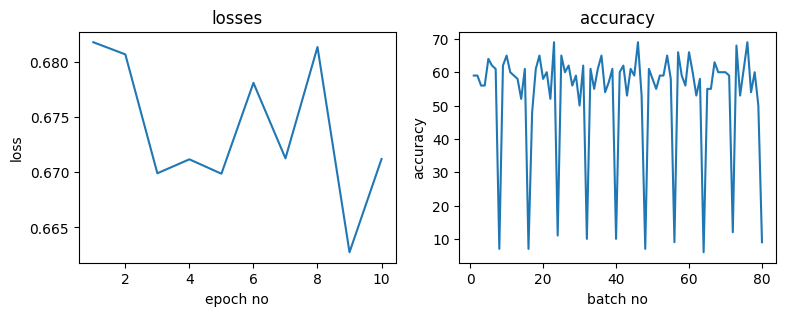

In [27]:
plot_loss_and_accuracy(losses, accuracy)

If you look at the accuracy graph, there are dips at certain intervals (it looks like). Let's find out why that happens

In [28]:
# analysis to find out about the dips in the accuracy
print([i for i,value in enumerate(accuracy) if value<10])

[7, 15, 47, 55, 63, 79]


After spending some time, I have concluded that the dips occour when the batch size is low (14). Which is fine since our model is not preforming very well

In [29]:
MODEL_PATH = '.\\titanic_net_1.pth'
torch.save(net.state_dict(), MODEL_PATH)

In [30]:
def calculate_testing_accuracy(model, testing_dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in testing_dataloader:
            labels = labels.squeeze()
            features = features.squeeze()
            outputs = model(features.float())
            outputs = (outputs > torch.Tensor([0.5])).long().squeeze()
            total+=outputs.size()[0]
            correct+= (outputs==labels).sum().item()
    return correct/total

In [31]:
""" since we don't have actual labels for testing data because this dataset was taken from kaggle,
    let's check how our model performs on the data that it was trained on
"""
print(calculate_testing_accuracy(net, training_dataloader))

0.5938375350140056


# Lessons learned
- check datatype of your tensor
- check the dimensions of your tensor and see if you're providing the right size tensor
- filter your dataframe to remove NaN values
- when you filter your datafrme, don't forget to reset the index of dataframe
- use the right type of loss function based on the application (binary classification / multiclass classifiction)
- use Tensor.squeeze() to remove all the dimensions of input of size 1 removed
- neural networks are not really good when you don't have considerable amount of data

## Experiment 2: Model with less no. of parameters

In [32]:
class LessParameterNet(nn.Module):
    
    def __init__(self):
        super(LessParameterNet, self).__init__()
        self.dl1 = nn.Linear(3, 4)
        self.dl2 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.dl1(x))
        x = self.sigmoid(self.dl2(x))
        return x

In [33]:
lepanet = LessParameterNet()
print(lepanet)

LessParameterNet(
  (dl1): Linear(in_features=3, out_features=4, bias=True)
  (dl2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [34]:
optimizer = optim.SGD(lepanet.parameters(), lr=0.01, momentum=0.9)
criterion = nn.BCELoss()

In [35]:
training_dataloader = data.DataLoader(training_data, shuffle=True, batch_size=100)

In [36]:
losses, accuracy = train(lepanet, training_dataloader, 20, optimizer, criterion)

tensor(1.5196, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0084, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8103, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7214, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7416, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7400, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6614, grad_fn=<BinaryCrossEntropyBackward0>)
epoch 1 done
tensor(0.7240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7439, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7145, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7262, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7315, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6990, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7291, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7262, grad_fn=<BinaryCrossEntropyBackward0>)
epoch 2 done
tensor(0.7202, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7168, grad_fn=<BinaryCrossEntropyBackward0>)
te

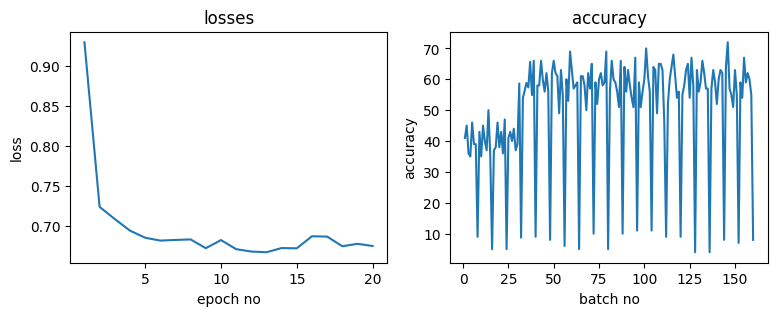

In [37]:
plot_loss_and_accuracy(losses, accuracy)

In [38]:
calculate_testing_accuracy(lepanet, training_dataloader)

0.5938375350140056

The accruracy does not look real good, I have failed to improve the accuracy of the model. I have tried to exploit something call overfitting and I'm already cheating by testing the model on the data that it was tested on. Since devising the best model for best results is not the purpose of this notebook, I guess I will leave this here, leaving the further fine tuning to you (yes you).

## Lessons learned
- If you don't have a lot of data to train your model, it is a good idea to reduce the number of parameters of your model


I guess this is it for now, since the purpose of this notebook was to get me kick started with pytorch, I think we are off to a good start as far as the start is concerned and as for improving the accuracy of the model, we can make a lot of changes

## TODO:
- do some data analysis first to look for patterns
- figure out more features (other than age, sex and class) that can contribute to improving the model's accuracy rather that adding some noise
- make changes in model hyperparameters like epochs, learning rates, optimizer and loss function